![upgit_20240516_1715801307.png](https://raw.githubusercontent.com/kcwc1029/obsidian-upgit-image/main/2024/05/upgit_20240516_1715801307.png)

![upgit_20240516_1715801344.png](https://raw.githubusercontent.com/kcwc1029/obsidian-upgit-image/main/2024/05/upgit_20240516_1715801344.png)

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow
tf.__version__

'2.16.1'

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

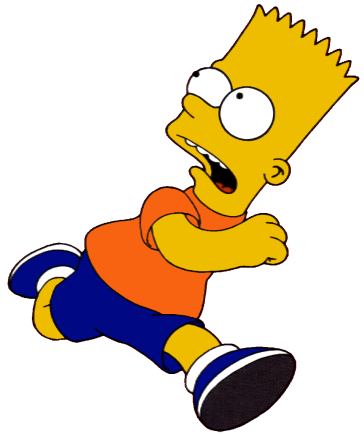

In [7]:
path = './Datasets/homer_bart_2.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

# 載入圖片
tf.keras.preprocessing.image.load_img('./homer_bart_2/training_set/bart/bart100.bmp')

## 圖片轉成訓練集與測試集

這邊將圖片處理成64 * 64大小

In [8]:
"""
資料預處理 (Data Preprocessing)
- 讀進image檔案。
- 將image內容解碼為RGB的像素。
- 將image轉換成浮點張量。
- 最後將像素值（ 0和255之間）重新縮放到[0,1]間隔，方便deep learning做運算。
以下我們透過程式碼介紹我們是如何做到資料預處理的。
Keras有一個圖像處理工具的module，位於keras.preprocessing.image。當中的ImageDataGenerator類別，
可以快速的自動將disk上的圖像文件轉換成tensors。我們將在這裡使用這個工具。
"""


# 訓練集
training_generator = ImageDataGenerator(rescale=1./255, # 对图像的每个像素值进行缩放，使其在 [0,1] 范围内。
                                        rotation_range=7, # 随机旋转图像的角度范围为 -7 度到 +7 度之间。
                                        horizontal_flip=True, # 随机水平翻转图像。
                                        zoom_range=0.2) # 随机缩放图像的范围为原始大小的 20%。


train_dataset = training_generator.flow_from_directory('./homer_bart_2/training_set',
                                                        target_size = (64, 64), # 调整图像的大小为指定的尺寸（64x64 像素）。
                                                        batch_size = 8, # 每个批次的图像数量。
                                                        class_mode = 'categorical', # 指定分类问题的类别模式，这里是 'categorical'，表示每个样本的类别由一个独热编码向量表示。
                                                       shuffle = True) # 表示在每个 epoch 开始时是否对图像进行随机打乱，以增加训练数据的随机性，防止模型记忆样本的顺序。


# 測試集
"""
在測試集上，通常不需要進行數據增強（如旋轉、翻轉、縮放等），因為測試集的目的是評估模型在真實數據上的性能，
而不是訓練模型。因此，測試集的 ImageDataGenerator 可以只進行最基本的圖像預處理，例如將像素值縮放到 [0,1] 的範圍內，
以便與訓練集的預處理保持一致。
"""
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('./homer_bart_2/test_set',
                                                     target_size = (64, 64),
                                                     batch_size = 1,
                                                     class_mode = 'categorical',
                                                     shuffle = False)


Found 215 images belonging to 2 classes.
Found 54 images belonging to 2 classes.


## 查看訓練集

In [9]:
# 查看資料分類
train_dataset.classes

# 查看資料分類集合
train_dataset.class_indices

{'bart': 0, 'homer': 1}

## 建構模型

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# 创建一个序列模型
network = Sequential()

# 添加卷积层和池化层，使用 ReLU 激活函数，在輸入圖像上應用 32 個 3x3 大小的卷積核
network.add(Conv2D(filters= 32, kernel_size=(3,3), input_shape = (64,64,3), activation='relu'))
network.add(MaxPooling2D(pool_size=(2,2)))

# 添加第二个卷积层和池化层，使用 ReLU 激活函数
network.add(Conv2D(32, (3,3), activation='relu'))
network.add(MaxPooling2D(pool_size=(2,2)))

# 添加第三个卷积层和池化层，使用 ReLU 激活函数
network.add(Conv2D(32, (3,3), activation='relu'))
network.add(MaxPooling2D(pool_size=(2,2)))

# 将多维输入展平为一维输入
network.add(Flatten())

# 添加全连接层，使用 ReLU 激活函数
# (1152 + 2) / 2 = 577
network.add(Dense(units = 577, activation='relu'))
network.add(Dense(units = 577, activation='relu'))

# 添加输出层，使用 softmax 激活函数进行分类，輸出為01兩個
network.add(Dense(units = 2, activation='softmax'))

/Users/chenweicheng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
network.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 577)            │       665,281 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 577)            │       333,506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         1,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,019,335 (3.89 MB)

 Trainable params: 1,019,335 (3.89 MB)

 Non-trainable params: 0 (0.00 B)

## 編譯模型

In [12]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics = ['accuracy'])
history = network.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
12/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6484 - loss: 0.8626

/Users/chenweicheng/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6063 - loss: 0.8012 - val_accuracy: 0.5185 - val_loss: 0.7372
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5797 - loss: 0.6581 - val_accuracy: 0.5370 - val_loss: 1.0631
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7636 - loss: 0.4345 - val_accuracy: 0.7037 - val_loss: 0.6554
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7835 - loss: 0.4826 - val_accuracy: 0.7593 - val_loss: 0.4954
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8068 - loss: 0.3402 - val_accuracy: 0.8148 - val_loss: 0.3657
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8260 - loss: 0.3532 - val_accuracy: 0.8519 - val_loss: 0.3686
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8431 - loss: 0.3209 - val_accuracy: 0.9074 - val_loss: 0.2512
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8680 - loss: 0.2619 - val_accuracy: 0.8704 - val_loss: 0.

## 評估網路

In [13]:
history.history.keys()
"""
'accuracy'：訓練集上的準確率（accuracy）。
'loss'：訓練集上的損失（loss）。
'val_accuracy'：測試集上的準確率（accuracy）。
'val_loss'：測試集上的損失（loss）。
"""

"\n'accuracy'：訓練集上的準確率（accuracy）。\n'loss'：訓練集上的損失（loss）。\n'val_accuracy'：測試集上的準確率（accuracy）。\n'val_loss'：測試集上的損失（loss）。\n"

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


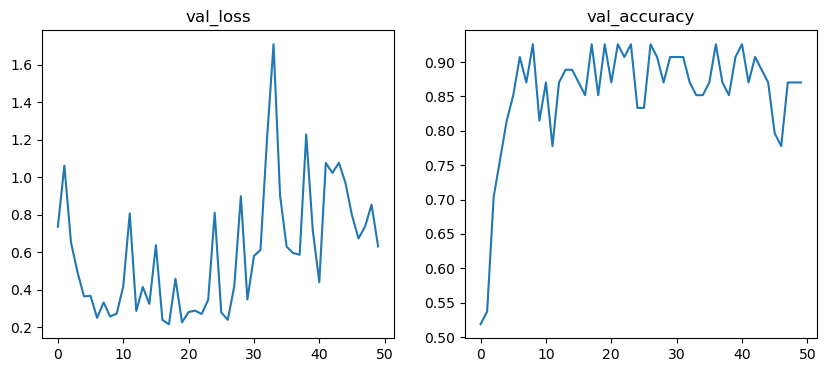

In [33]:
# plt.figure(figsize=(4, 2))
# plt.plot(history.history['val_loss'])

# 打印训练历史记录中的所有键
print(history.history.keys())

# 绘制损失函数和准确率曲线在同一张图上，一左一右
plt.figure(figsize=(10, 4))

# 损失函数曲线在左侧
plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'])
plt.title('val_loss')

# 准确率曲线在右侧
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'])
plt.title('val_accuracy')

# 显示图形
plt.show()


## 進行預測

In [34]:
# 標籤集
print(test_dataset.class_indices)

predictions = network.predict(test_dataset)
print(predictions[:5])

predictions = np.argmax(predictions, axis = 1)
print("預測值")
print(predictions)

print("答案")
print(test_dataset.classes)

{'bart': 0, 'homer': 1}
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[1.0000000e+00 2.6931644e-19]
 [1.0000000e+00 3.2157343e-09]
 [1.4521863e-02 9.8547816e-01]
 [1.0000000e+00 2.6865589e-17]
 [1.0000000e+00 4.8368871e-22]]
預測值
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1]
答案
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


## 評估模型

0.8703703703703703
              precision    recall  f1-score   support

           0       0.89      0.86      0.87        28
           1       0.85      0.88      0.87        26

    accuracy                           0.87        54
   macro avg       0.87      0.87      0.87        54
weighted avg       0.87      0.87      0.87        54



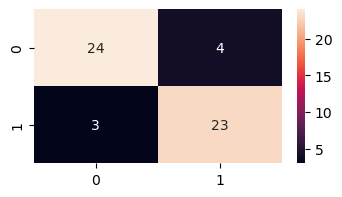

In [20]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_dataset.classes, predictions))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, predictions)
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True)

from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes, predictions))

## 儲存/載入模型

In [22]:
# 儲存模型结构
model_json = network.to_json()
with open('network.json','w') as json_file:
  json_file.write(model_json)

In [23]:
# 儲存模型參數
from keras.models import save_model
network_saved = save_model(network, './weights.hdf5')

In [24]:
# 讀入模型架構
with open('network.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"module": "keras", "class_name": "Sequential", "config": {"name": "sequential", "trainable": true, "dtype": "float32", "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_shape": [null, 64, 64, 3], "dtype": "float32", "sparse": false, "name": "input_layer"}, "registered_name": null}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {}, "registered_name": null}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_cons

In [25]:
# 載入模型參數
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('weights.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [26]:
network_loaded.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 577)            │       665,281 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 577)            │       333,506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         1,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,019,335 (3.89 MB)

 Trainable params: 1,019,335 (3.89 MB)

 Non-trainable params: 0 (0.00 B)

## 辨識單張圖片

(536, 514, 3)
(1, 64, 64, 3)
tf.Tensor([[0.600099  0.3999009]], shape=(1, 2), dtype=float32)
0
Bart


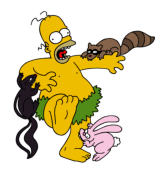

In [43]:
image = cv2.imread('./homer_bart_2/test_set/homer/homer15.bmp')
plt.figure(figsize=(4, 2))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 將 OpenCV 中的 BGR 格式轉換為 RGB 格式，因為 Matplotlib 預期的是 RGB 格式
plt.axis('off')  # 隱藏坐標軸
plt.imshow(image)


# 圖片預處理
print(image.shape) # (536, 514, 3)
image = cv2.resize(image, (64, 64)) # 將該圖片中成64 * 64
image = image / 255
# 將圖像的形狀重新調整為適合輸入到神經網絡中的形狀。
image = image.reshape(-1, 64, 64, 3)
print(image.shape) # (536, 514, 3)

# 進行預測
result = network_loaded(image)
print(result)
result = np.argmax(result)
print(result)
ans = 'Bart' if result == 0 else 'Homer'
print(ans)
